In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

2025-03-30 21:48:16.548426: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 21:48:16.549395: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-30 21:48:16.552122: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-30 21:48:16.558673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743364096.570022  128409 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743364096.57

In [2]:
# check tensorflow version for reproducibility
print(tf.__version__)
print(tf.keras.__spec__)

2.18.0
ModuleSpec(name='keras._tf_keras.keras', loader=<_frozen_importlib_external.SourceFileLoader object at 0x77900639bdf0>, origin='/home/michele/.local/lib/python3.10/site-packages/keras/_tf_keras/keras/__init__.py', submodule_search_locations=['/home/michele/.local/lib/python3.10/site-packages/keras/_tf_keras/keras'])


# Load data and checks on labels

Load the three labeled csv files and combine them in one dataframe. Plot also the total number of entries 
for each label using `pandas.DataFrame.describe` method.\
What we can notice is that the total number of bottom jets is approximately two times (four times) the number of charm jets (light jets).
This means that we have to properly normalize the amount of data per each class when we will split the total dataset in train, validation and test.
If we don't properly do this there could be the risk of introducing some error during the training stage, since the number of data with `mc_flavour = 5` is larger than the other two

In [3]:
ljet_data = pd.read_csv('jet_data/ljet_train.csv')
cjet_data = pd.read_csv('jet_data/cjet_train.csv')
bjet_data = pd.read_csv('jet_data/bjet_train.csv')

jet_data = pd.concat([ljet_data, cjet_data, bjet_data], axis=0).reset_index(drop=True)
n_labels = jet_data['mc_flavour'].unique()
print('List of different labels = ', n_labels)

# associate to each label a name
flavour_labels = {0: 'light jets', 4: 'charm jets', 5: 'bottom jets'}
for flavour, name in flavour_labels.items():
    print(f'Label {flavour}: {name}')

flavour_palette = {0:'blue', 4:'orange', 5:'red'}

List of different labels =  [0 4 5]
Label 0: light jets
Label 4: charm jets
Label 5: bottom jets


# Deep Neural Network for classification

In [4]:
from keras import Sequential, layers, optimizers, losses, metrics, utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
features = jet_data.columns.drop(['mc_flavour', 'PT'])
n_labels = jet_data['mc_flavour'].nunique()

print(f'Number of features = {features.size}')
print(f'Number of labels = {n_labels}')

Number of features = 13
Number of labels = 3


In [6]:
simple_dnn = Sequential(name='simple_dnn')

# the number of nodes of the input layer is the number of features used 
input_layer = layers.Input(shape=(features.size,), name='Input')
simple_dnn.add(input_layer)

# first hidden layer with 16 neurons and ReLU as activation function
hidden1 = layers.Dense(16, activation='relu', name='Hidden1')
simple_dnn.add(hidden1)

# second hidden layer with 32 neurons and ReLU as activation function
hidden2 = layers.Dense(16, activation='relu', name='Hidden2')
simple_dnn.add(hidden2)

# third hidden layer with 32 neurons and sigmoid as activation function
hidden3 = layers.Dense(16, activation='sigmoid', name='Hidden3')
simple_dnn.add(hidden3)

# output layer with 3 neurons and softmax becuase softmax is the best activation function
# for classification problem with more than 2 classes
output_layer = layers.Dense(n_labels, activation='softmax', name='Output')
simple_dnn.add(output_layer)

simple_dnn.summary()

2025-03-30 21:48:40.407473: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "simple_dnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden1 (Dense)                 │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 819 (3.20 KB)

 Trainable params: 819 (3.20 KB)

 Non-trainable params: 0 (0.00 B)

The total number of parameters for each layer is given considering the number of neurons of the previous layer times the neurons of the current layers plus the biases:

Total parameters = weights + biases = Input_size $\times$ neurons + biases

Neurons and biases depend on the current layer. Input_size depends on the previous layer

In [7]:
optimizer = optimizers.SGD()
loss = losses.CategoricalCrossentropy()
metric = metrics.CategoricalAccuracy()

simple_dnn.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Once the model has been compiled, split dataset in training, validation (for DNN is importan) and test

In [8]:
X = jet_data[features]
y = jet_data['mc_flavour']

# original labels
original_labels = y.copy()

# map 4 to 1, 5 to 2 and keep 0 as it is
y = pd.Series(np.where(original_labels == 4, 1, np.where(original_labels == 5, 2, original_labels)))

# one hot encode labels
y = utils.to_categorical(y, n_labels)

# train+validation and test dateset
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# split in train and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.7/0.9, random_state=42, stratify=y_train_val)

print(f"Training set: {X_train.shape}") # 70% training
print(f"Validation set: {X_val.shape}") # 20% validation
print(f"Test set: {X_test.shape}")      # 10% test

# normalize input training, validation and test (mean = 0, stddev = 1)
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

Training set: (95220, 13)
Validation set: (27207, 13)
Test set: (13603, 13)


In [9]:
history_simple = simple_dnn.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)

Epoch 1/50
2976/2976 ━━━━━━━━━━━━━━━━━━━━ 2s 689us/step - categorical_accuracy: 0.6040 - loss: 0.9124 - val_categorical_accuracy: 0.6643 - val_loss: 0.7504
Epoch 2/50
2976/2976 ━━━━━━━━━━━━━━━━━━━━ 2s 663us/step - categorical_accuracy: 0.6789 - loss: 0.7276 - val_categorical_accuracy: 0.7011 - val_loss: 0.6821
Epoch 3/50
2976/2976 ━━━━━━━━━━━━━━━━━━━━ 2s 670us/step - categorical_accuracy: 0.7105 - loss: 0.6713 - val_categorical_accuracy: 0.7343 - val_loss: 0.6298
Epoch 4/50
2976/2976 ━━━━━━━━━━━━━━━━━━━━ 2s 678us/step - categorical_accuracy: 0.7469 - loss: 0.6149 - val_categorical_accuracy: 0.7562 - val_loss: 0.5883
Epoch 5/50
2976/2976 ━━━━━━━━━━━━━━━━━━━━ 2s 686us/step - categorical_accuracy: 0.7598 - loss: 0.5801 - val_categorical_accuracy: 0.7609 - val_loss: 0.5741
Epoch 6/50
2976/2976 ━━━━━━━━━━━━━━━━━━━━ 2s 665us/step - categorical_accuracy: 0.7626 - loss: 0.5700 - val_categorical_accuracy: 0.7665 - val_loss: 0.5649
Epoch 7/50
2976/2976 ━━━━━━━━━━━━━━━━━━━━ 2s 684us/step - catego

In [10]:
simple_dnn.evaluate(X_test, y_test, verbose=1)

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - categorical_accuracy: 0.7838 - loss: 0.5218


[0.5283644795417786, 0.7811512351036072]

In [11]:
def plot_loss_accuracy(history):
    history_df = pd.DataFrame(history.history)

    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(14, 5))  

    # plot loss
    history_df[['loss', 'val_loss']].plot(ax=ax_loss)
    ax_loss.set_title("Loss over Epochs", fontsize=15)
    ax_loss.set_xlabel("Epoch", fontsize=15)
    ax_loss.set_ylabel("Loss", fontsize=15)
    ax_loss.grid()
    ax_loss.legend(["Training Loss", "Validation Loss"], fontsize=15)
    y_min = history_df[['loss', 'val_loss']].min().min() * 0.9
    y_max = history_df[['loss', 'val_loss']].max().max() * 1.1
    ax_loss.set_ylim(y_min, y_max)

    # plot accuracy
    history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot(ax=ax_acc)
    ax_acc.set_title("Accuracy over Epochs", fontsize=15)
    ax_acc.set_xlabel("Epoch", fontsize=15)
    ax_acc.set_ylabel("Accuracy", fontsize=15)
    ax_acc.grid()
    ax_acc.legend(["Training Accuracy", "Validation Accuracy"], fontsize=15)
    y_min = history_df[['categorical_accuracy', 'val_categorical_accuracy']].min().min() * 0.9
    y_max = history_df[['categorical_accuracy', 'val_categorical_accuracy']].max().max() * 1.1
    ax_acc.set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()

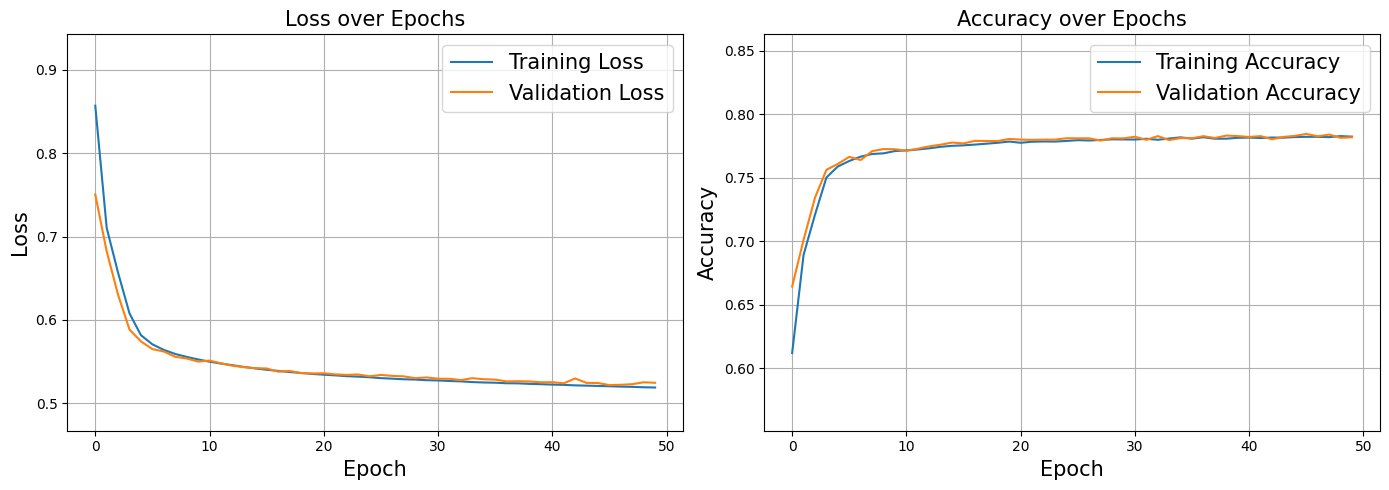

In [12]:
plot_loss_accuracy(history_simple)

In [13]:
def plot_confusion_matrix(model:Sequential):
    y_test_pred = model.predict(X_test).argmax(axis=1)  # Convert probabilities to class labels
    cm = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred, labels=[0, 1, 2], normalize='true')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Light', 'Charm', 'Bottom'])
    disp.plot(cmap=plt.cm.Blues)

    plt.title("Confusion Matrix")
    plt.show()

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


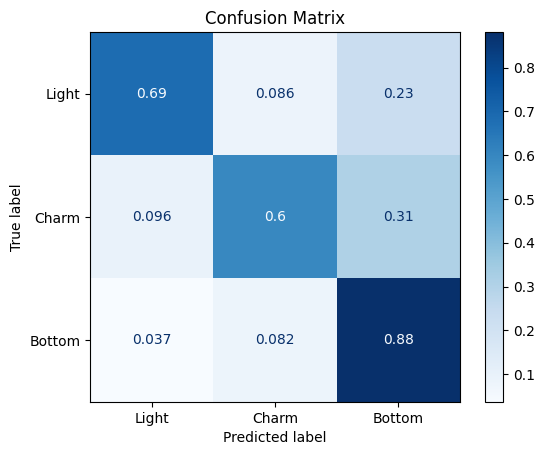

In [14]:
plot_confusion_matrix(simple_dnn)

### Performances of DNN: 
Accuracy is 78.9% and from confusion matrix we can see that charm jets are often (0.26) classfied as bottom. So it has the same problems of the random forest classifier

# Optimization of the DNN

In [15]:
from sklearn.utils.class_weight import compute_class_weight
from keras import callbacks, regularizers

To optimize DNN performances we can apply weights to different classes, since we know that there is class unbalance. Class weight can be used during training

In [16]:
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print('Class counts from training dataset = ', dict(zip(unique, counts)))


class_weights = compute_class_weight('balanced', classes=unique, y=np.argmax(y_train, axis=1))
class_weight_dict = {i: class_weights[i]/sum(class_weights) for i in range(len(class_weights))}
print('Class weights = ', class_weight_dict)

Class counts from training dataset =  {0: 14471, 1: 23453, 2: 57296}
Class weights =  {0: 0.5348775173880599, 1: 0.33003080860114337, 2: 0.13509167401079683}


Let's build a more complex model: add the number of neurons and hidden layers. We can also take into accounts parameters regarding the optimizer for example

In [17]:
opt_dnn = Sequential(name='optimized_dnn')

opt_dnn.add(layers.Input(shape=(features.size,), name='Input'))

n_hidden = 10
for layer in range(n_hidden):
    if layer == 0: neurons = 32
    elif layer == n_hidden - 1: neurons = 64
    else: neurons = 32

    opt_dnn.add(layers.Dense(neurons, activation='relu', name=f'Hidden_{layer}', kernel_regularizer=regularizers.L2(1e-4),
                             kernel_initializer='he_normal'))
    opt_dnn.add(layers.BatchNormalization())
    #opt_dnn.add(layers.Dropout(0.3))

opt_dnn.add(layers.Dense(n_labels, activation='softmax', name='Output'))

opt_dnn.summary()

Model: "optimized_dnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_0 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_1 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_2 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_3 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_4 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_5 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_6 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_7 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_8 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_9 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 12,611 (49.26 KB)

 Trainable params: 11,907 (46.51 KB)

 Non-trainable params: 704 (2.75 KB)

Further optimization can be done on the optimizer. Loss sparse categorical crossentropy should be the best loss function for this classification problem.\
Also sparse categorical accuracy should be the best metric for this case

Categorical crossentropy:
$ J(\vec{w}) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right] $

In [18]:
# learning rate 1e-4
#scheduler = optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1e4, decay_rate=0.9)
optimizer = optimizers.Adam(learning_rate=1e-4)
loss = losses.CategoricalCrossentropy()
metric = metrics.CategoricalAccuracy()

opt_dnn.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [19]:
def reset_weights(model:Sequential):
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.assign(layer.kernel_initializer(tf.shape(layer.kernel)))
        if hasattr(layer, 'bias_initializer'):
            layer.bias.assign(layer.bias_initializer(tf.shape(layer.bias)))

Overfitting problems related to a high number of epochs can be fixes using early stopping techniques

In [20]:
#reset_weights(opt_dnn)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# add also class_weight to train the model this time
# Increase number of epochs to 150. It can be too high -> overfitting problems
history = opt_dnn.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=200, 
                      verbose=1, batch_size=512, callbacks=[early_stop])

Epoch 1/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - categorical_accuracy: 0.3983 - loss: 1.3474 - val_categorical_accuracy: 0.5475 - val_loss: 1.0612
Epoch 2/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categorical_accuracy: 0.5567 - loss: 1.0569 - val_categorical_accuracy: 0.6247 - val_loss: 0.9565
Epoch 3/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categorical_accuracy: 0.6182 - loss: 0.9617 - val_categorical_accuracy: 0.6504 - val_loss: 0.8994
Epoch 4/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categorical_accuracy: 0.6462 - loss: 0.9058 - val_categorical_accuracy: 0.6652 - val_loss: 0.8587
Epoch 5/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categorical_accuracy: 0.6667 - loss: 0.8617 - val_categorical_accuracy: 0.6737 - val_loss: 0.8296
Epoch 6/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categorical_accuracy: 0.6757 - loss: 0.8350 - val_categorical_accuracy: 0.6810 - val_loss: 0.8094
Epoch 7/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categorical_accuracy: 0.681

In [21]:
opt_dnn.evaluate(X_test, y_test, verbose=1)

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - categorical_accuracy: 0.7786 - loss: 0.5785


[0.5829491019248962, 0.7785047292709351]

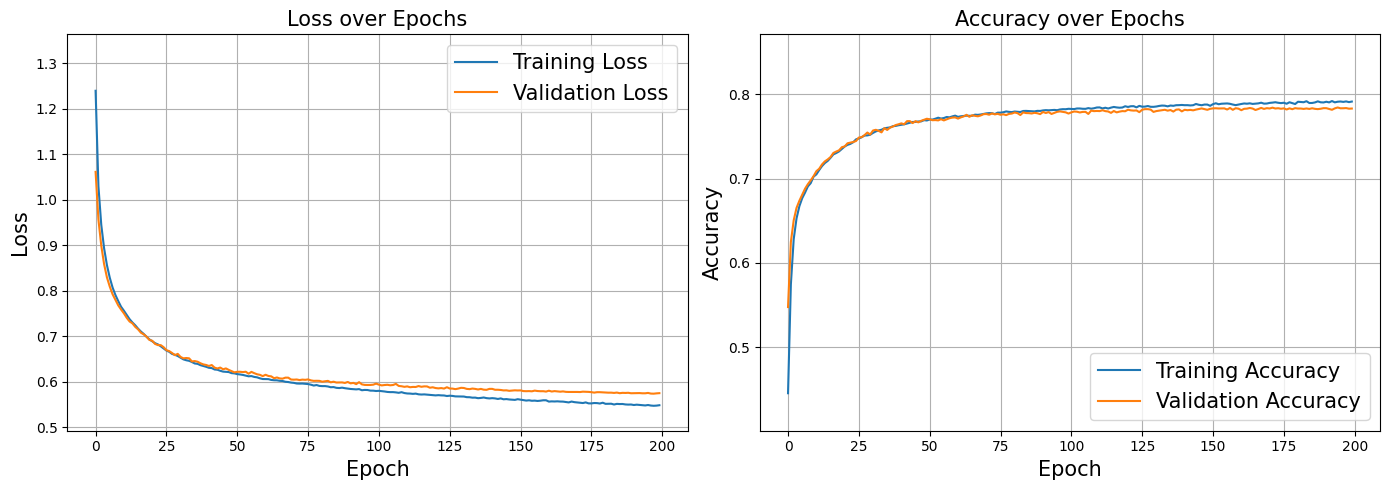

In [22]:
plot_loss_accuracy(history)

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


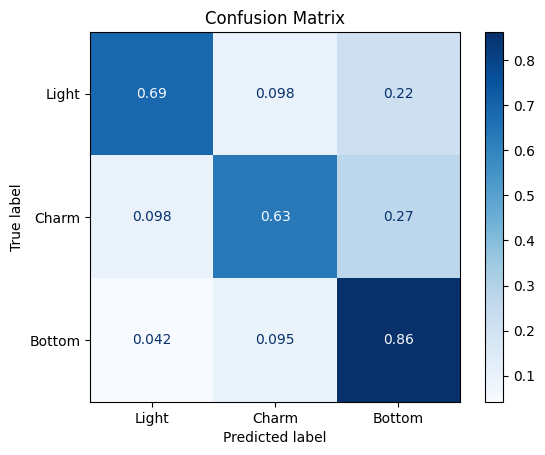

In [23]:
plot_confusion_matrix(opt_dnn)